# Portugese Bank Analysis
#### Submission for MAC x OCRUG Data Science Hackathon Event

#### Team Math Geeks + Ryan

Team Members: Ryan Luu, Kent Jitpatima, Sunny Zhou, Vu Tran, and Alex Oineza

# Table of Content

1. Business Problem
2. Data Collection and Cleaning
3. Data Analysis
4. Conclusion

# Dataset Detail

Bank-full.csv contains all 45,211 observations, ordered by data from May 2008 to November 2010.

The data is related with direct marketing campaigns of a Portuguese Bank institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would (or not) subscribed.

Categorical Variables <br>
Job: Occupation (management, technician, entrepreneur, students, retired, etc.) <br>
Marital: Single, Married, Divorce (also includes widowed) <br>
Education: Unknown, Primary, Secondary, Tertiary <br>
Contact: Communication method (telephone, cellular, unknown) <br>
Month: Month of last contact <br>
POutcome: Outcome of the previous marketing campaign (success, failure, other, unknown) <br>

Numerical Variables <br>
Age: Age <br>
Balance: Average yearly balance (in euros) <br>
Day: Last contact day of the month <br>
Duration: Last contact duration (in seconds) <br>
Campaign: Number of performed contacts for this campaign for this client  <br>
Pdays: Number of days passed since the last contact (-1 means client was not previous contacted.) <br>
Previous: Number of contacts performed before this campaign and for this client. <br>

Binary Variables <br>
Y: Did the client subscribe a term deposit? <br>
Loan: Does the client have a personal loan? <br>
Housing: Does the client have a housing loan? <br>
Default: Does the client have credit in the default? <br>

# Set-Up

In [47]:
data <- read.csv("bank-full.csv", TRUE, ';')

In [118]:
install.packages("gridExtra")
#Packages
library(randomForest)
library(caret)
library(ggplot2)
library(lubridate)
library(scales)
library(gridExtra)
library(DMwR)

Installing package into 'C:/Users/Ryan Luu/Documents/R/win-library/3.6'
(as 'lib' is unspecified)
Warning message:
"package 'gridExtra' is in use and will not be installed"Loading required package: grid
Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


# Data Visualization

Before performing any data analysis, we like to see what kind of data we are working with.

In [50]:
head(data)

age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,no


In [51]:
str(data)

'data.frame':	45211 obs. of  17 variables:
 $ age      : int  58 44 33 47 33 35 28 42 58 43 ...
 $ job      : Factor w/ 12 levels "admin.","blue-collar",..: 5 10 3 2 12 5 5 3 6 10 ...
 $ marital  : Factor w/ 3 levels "divorced","married",..: 2 3 2 2 3 2 3 1 2 3 ...
 $ education: Factor w/ 4 levels "primary","secondary",..: 3 2 2 4 4 3 3 3 1 2 ...
 $ default  : Factor w/ 2 levels "no","yes": 1 1 1 1 1 1 1 2 1 1 ...
 $ balance  : int  2143 29 2 1506 1 231 447 2 121 593 ...
 $ housing  : Factor w/ 2 levels "no","yes": 2 2 2 2 1 2 2 2 2 2 ...
 $ loan     : Factor w/ 2 levels "no","yes": 1 1 2 1 1 1 2 1 1 1 ...
 $ contact  : Factor w/ 3 levels "cellular","telephone",..: 3 3 3 3 3 3 3 3 3 3 ...
 $ day      : int  5 5 5 5 5 5 5 5 5 5 ...
 $ month    : Factor w/ 12 levels "apr","aug","dec",..: 9 9 9 9 9 9 9 9 9 9 ...
 $ duration : int  261 151 76 92 198 139 217 380 50 55 ...
 $ campaign : int  1 1 1 1 1 1 1 1 1 1 ...
 $ pdays    : int  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 ...
 $ previous : int  0 0 0

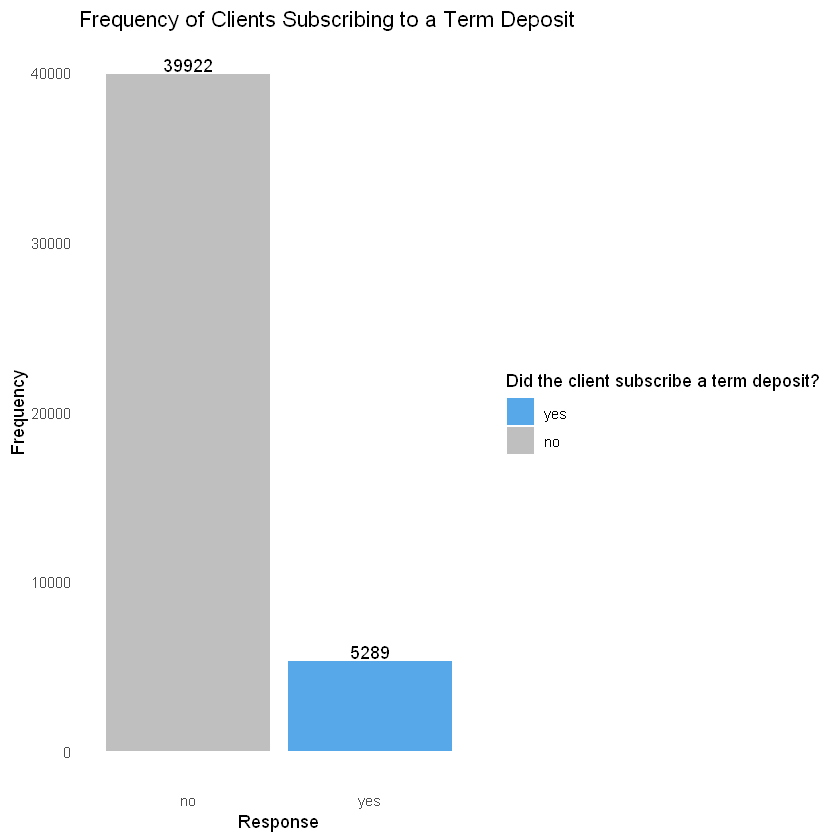

In [101]:
#Color Code
colory <- "#56a8e8"
colorn <- "grey75"

ggplot(data, aes(y, fill = y)) + geom_bar() +
  theme_minimal()+
  scale_fill_manual(values = c(colorn,colory)) +
  guides(fill = guide_legend(reverse = TRUE)) +
  geom_text(stat = 'count',aes(label =..count.., vjust = -0.2)) +
  theme(panel.background=element_blank(),panel.border=element_blank(),panel.grid.major=element_blank(),
          panel.grid.minor=element_blank(),plot.background=element_blank()) +
  labs(title = "Frequency of Clients Subscribing to a Term Deposit",
       x = "Response",
       y = "Frequency",
       fill = "Did the client subscribe a term deposit?")

# Business Problem

Based on this graph, we immediately knew there is an imbalance of those who subsribed to a term deposit and those who did not. If we were to use create a predictive model, we need to ensure that there is enough observations who responded "yes" in both the train and test dataframe.

Here is the Business Problem: The callers contact many clients but only a rough percentage of them subsribe to a bank term deposit. Our goal is to determine which demographic of customers the bank should be focusing and calling. For example, are younger people more likely to subscribe to a bank term? What professions are more likely to subscribe? By knowing which audience is their target audience, the bank can properly allocate its resources and call those who are likely to subsribe. 

We will also create a predictive model in predicting whether a client will subsribe to a bank term deposit. We will identify which features are the most important in the model. 

# Data Partitioning

In [53]:
#Create two new dataframe, data_yes has all of the obs with y=yes, data_no has all of the obs with y=no
data_yes <- data[ which(data$y=='yes'),]
data_no <- data[ which(data$y=='no'),]

set.seed(1234)
ind <- sample(2,nrow(data_no), replace = TRUE, prob = c(0.7,0.3))
train <- data_no[ind==1,]
test <- data_no[ind==2,]

ind <- sample(2,nrow(data_yes), replace = TRUE, prob = c(0.7,0.3))
train1 <- data_yes[ind==1,]
test1 <- data_yes[ind==2,]

train <- rbind(train, train1)
test <- rbind(test, test1)

In [54]:
rf <- randomForest(y~., data=train)

In [55]:
print(rf)


Call:
 randomForest(formula = y ~ ., data = train) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 4

        OOB estimate of  error rate: 9.19%
Confusion matrix:
       no  yes class.error
no  26996  986  0.03523694
yes  1922 1739  0.52499317


In [108]:
library(caret)
p1 <- predict(rf, train)
confusionMatrix(p1, train$y)

#Prediction & Confusion MAtrix - test data
p2 <- predict(rf, test)
confusionMatrix(p2, test$y)

Confusion Matrix and Statistics

          Reference
Prediction    no   yes
       no  27982     1
       yes     0  3660
                                     
               Accuracy : 1          
                 95% CI : (0.9998, 1)
    No Information Rate : 0.8843     
    P-Value [Acc > NIR] : <2e-16     
                                     
                  Kappa : 0.9998     
                                     
 Mcnemar's Test P-Value : 1          
                                     
            Sensitivity : 1.0000     
            Specificity : 0.9997     
         Pos Pred Value : 1.0000     
         Neg Pred Value : 1.0000     
             Prevalence : 0.8843     
         Detection Rate : 0.8843     
   Detection Prevalence : 0.8843     
      Balanced Accuracy : 0.9999     
                                     
       'Positive' Class : no         
                                     

Confusion Matrix and Statistics

          Reference
Prediction    no   yes
       no  11515   838
       yes   425   790
                                          
               Accuracy : 0.9069          
                 95% CI : (0.9019, 0.9118)
    No Information Rate : 0.88            
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.505           
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.9644          
            Specificity : 0.4853          
         Pos Pred Value : 0.9322          
         Neg Pred Value : 0.6502          
             Prevalence : 0.8800          
         Detection Rate : 0.8487          
   Detection Prevalence : 0.9105          
      Balanced Accuracy : 0.7248          
                                          
       'Positive' Class : no              
                  

Something is obviously wrong. Even though this model is more than 90% accurate, accuracy of the model is not the best indicator in measuring the performance. The model performs extremely well in predicting whether a client will reject a bank term deposit. However, it is wrong more than half the time when trying to predict whether a client actually does subsribe to a bank term.<br>

Because of such imbalance of yes and no, the model can easily keep predicting no for the most part and still be fairly accurate. For example, if the answers of a True or False test is 80% true and I guess True for all of the questions, I will get an 80% on the test. Just because I got 80% on the test is not an actual representation of how well I know the test material. Perhaps a classification analysis is not the best route?

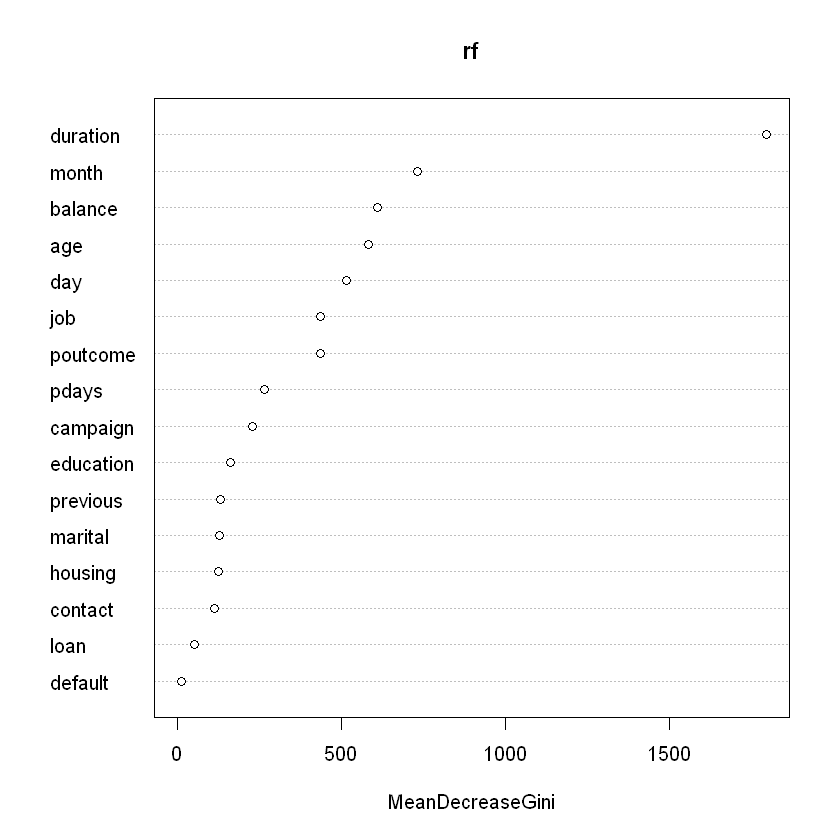

In [56]:
varImpPlot(rf)

Questions to ask: <br>
Why is duration the most influential variable in predicting who will subscribe to a bank term deposit? <br>
Why is the day of the month even a factor? Interesting. We will need to further investigate. <br><br>
Overall, variables such as balance and age makes sense in predicting. Here is our hypothesis on why those variables are significant: <br>
If you have a large balance, you are likely able to afford a term deposit. As for age, here are the assumptions: When you are young, you probably got your first job and want to invest early. However, by the time you are around 30, you are less likely to invest because you have more financial constraints (having children). And Retired people are more likely to invest because they don't spend much perhaps and want to work on their retirement funds. <br><Br> But why duration and day? <br><br>

# Investigating Duration

In [57]:
summary(data_yes$duration)
summary(data_no$duration)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    8.0   244.0   426.0   537.3   725.0  3881.0 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0    95.0   164.0   221.2   279.0  4918.0 

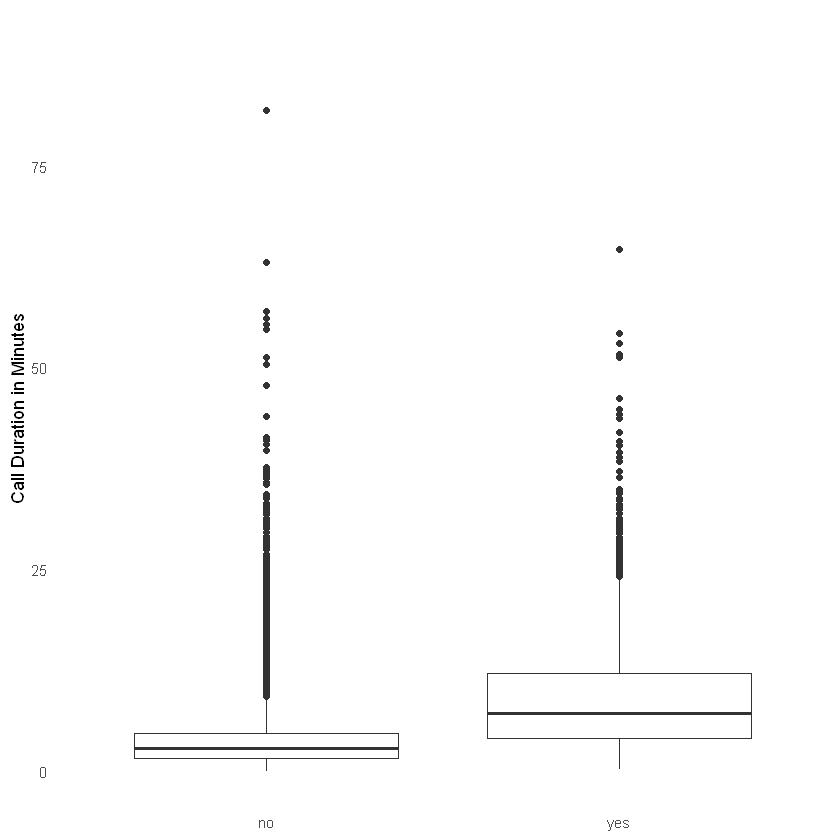

In [99]:
ggplot(data, aes(y, duration/60)) + 
geom_boxplot() + 
theme_minimal() +
theme(axis.line=element_blank(),legend.position="bottom",
          panel.background=element_blank(),panel.border=element_blank(),panel.grid.major=element_blank(),
          panel.grid.minor=element_blank(),plot.background=element_blank()) +
ylim(0, 90) +
xlab(NULL) + 
ylab("Call Duration in Minutes") +
labs(fill = "Subscribe Bank Term Depsoit")

After some discussion, we feel that we should remove the variable duration because it does not make sense on how it can predict whether a client will subscribe to a term deposit. Maybe the longer you talk to the client, they will eventually "give-in" and subscribe to a term deposit? Most likely not - they would probably just hang up on the bank teller. Perhaps why the calls are so long for people who subsribed yes is because they were already planning to subsribe and were just asking questings regarding the bond. Nonetheless, the length of the phone call duration should not be a feature to consider.

In [60]:
#Convert Month into month number
data$month_num[data$month == 'jan'] = 1 
data$month_num[data$month == 'feb'] = 2 
data$month_num[data$month == 'mar'] = 3 
data$month_num[data$month == 'apr'] = 4 
data$month_num[data$month == 'may'] = 5 
data$month_num[data$month == 'jun'] = 6 
data$month_num[data$month == 'jul'] = 7 
data$month_num[data$month == 'aug'] = 8 
data$month_num[data$month == 'sep'] = 9 
data$month_num[data$month == 'oct'] = 10 
data$month_num[data$month == 'nov'] = 11
data$month_num[data$month == 'dec'] = 12 

#Create a date column by combining month number and day. 2008 is a dummy year since observations did not include the year of the obs.
data$date <- paste(data$month_num,data$day, "2008")
data$date <- mdy(data$date)

# Investigating Day and Month

#### Let's observe the number of observation for each month

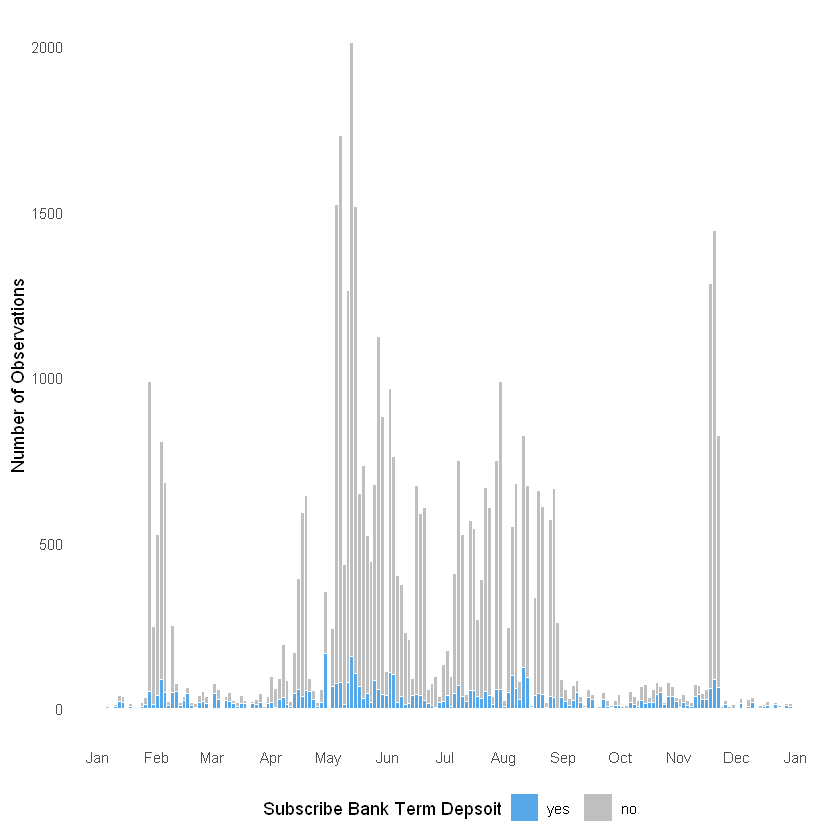

In [61]:
ggplot(data, aes(date, fill = y)) + 
  geom_histogram(binwidth = 2,colour = "white", size = 0.1) + 
  theme_minimal() +
  scale_fill_manual(values = c(colorn,colory)) +
  guides(fill = guide_legend(reverse = TRUE)) +
  scale_x_date(date_labels="%b",date_breaks  ="1 month") + 
  theme(axis.line=element_blank(), legend.position="bottom",
          panel.background=element_blank(),panel.border=element_blank(),panel.grid.major=element_blank(),
          panel.grid.minor=element_blank(),plot.background=element_blank()) +
  xlab(NULL) + 
  ylab("Number of Observations") + 
  labs(fill = "Subscribe Bank Term Depsoit")


Based on this graph, it appears that there are spikes in number of observations recorded. We are not sure why but my team has decided to make the assumption that perhaps the calls in the marketing campaigns were scheduled that way. For example, the callers were tasked to operate on specific months and days when carrying out the campaign. However, because of this, it skews the results. As a result, we feel that we should remove the variables month and days if we want to build a model in predicting term deposits. 

# Investigating Age

Now that we noticed age seems to be a important feature in predicting, we are going to split the observations into three age groups to test our hypothesis.

In [62]:
data_age1 <- data[which(data$age>=18 & data$age <30),]
data_age2 <- data[which(data$age>=30 & data$age <60),]
data_age3 <- data[which(data$age>60),]

In [63]:
p1 <- ggplot(data_age1, aes(y, fill = y)) + 
  geom_bar(show.legend = FALSE) +
  theme_minimal()+
  scale_fill_manual(values = c(colorn,colory)) +
  guides(fill = guide_legend(reverse = TRUE)) +
  theme(axis.line=element_blank(),  
          axis.title.y=element_blank(),
          panel.background=element_blank(),panel.border=element_blank(),panel.grid.major=element_blank(),
          panel.grid.minor=element_blank(),plot.background=element_blank()) +
  labs(title = "Age Group 18-29",
       x = NULL,
       y = "Frequency",
       fill = "Did the client subscribe a term deposit?")

p2 <- ggplot(data_age2, aes(y, fill = y)) + 
  geom_bar(show.legend = FALSE) +
  theme_minimal()+
  scale_fill_manual(values = c(colorn,colory)) +
  guides(fill = guide_legend(reverse = TRUE)) +
  theme(axis.line=element_blank(),
          axis.title.y=element_blank(),
          panel.background=element_blank(),panel.border=element_blank(),panel.grid.major=element_blank(),
          panel.grid.minor=element_blank(),plot.background=element_blank()) +
  labs(title = "Age Group 30-59",
       x = NULL,
       y = NULL,
       fill = "Did the client subscribe a term deposit?")

p3 <- ggplot(data_age3, aes(y, fill = y)) + 
  geom_bar(show.legend = FALSE) +
  theme_minimal()+
  scale_fill_manual(values = c(colorn,colory)) +
  guides(fill = guide_legend(reverse = TRUE)) +
  theme(axis.line=element_blank(),
          panel.background=element_blank(),panel.border=element_blank(),panel.grid.major=element_blank(),
          panel.grid.minor=element_blank(),plot.background=element_blank()) +
  labs(title = "Age Group 60+",
       x = NULL,
       y = NULL,
       fill = "Did the client subscribe a term deposit?")

# Frequency of Term Deposit Subscription by Age Group

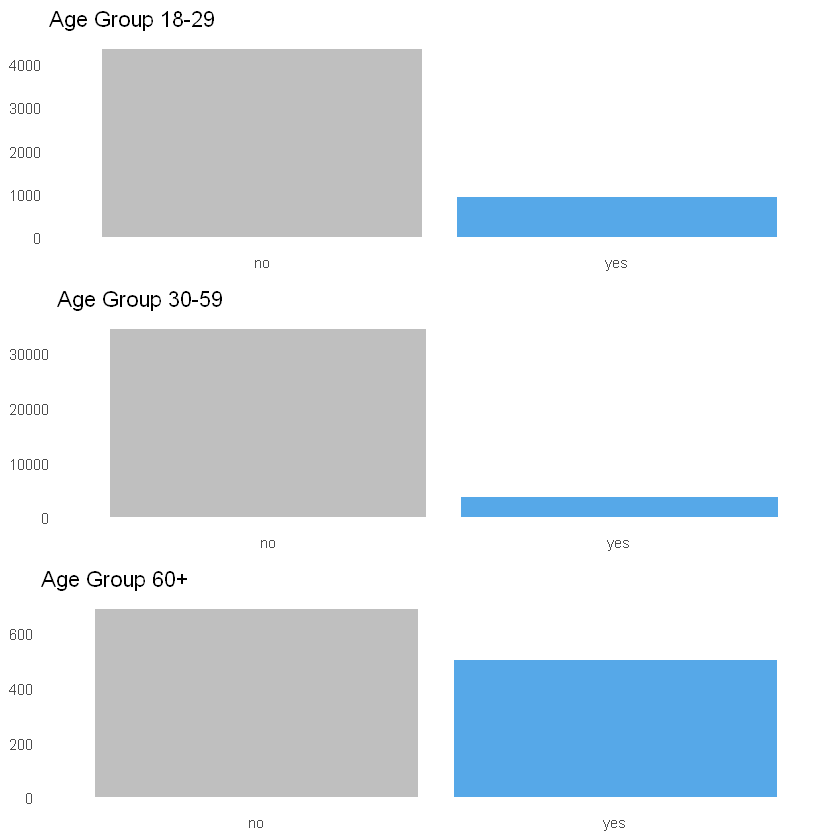

In [64]:
grid.arrange(p1, p2, p3, nrow = 3)

In [65]:
summary(data_age1$balance)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-8019.0    64.0   339.0   986.6   975.0 36252.0 

In [66]:
summary(data_age2$balance)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
 -6847.0     69.0    449.5   1362.9   1437.0 102127.0 

In [67]:
summary(data_age3$balance)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   -492     424    1341    2678    2991   81204 

# Reattempt at randomForest with synthetic data

Removing duration, month, and day from the date column since we believe it serves no purpose in the predictive model. Earlier, we tried to solve the imbalance of yes and no by trying to distribute the 'yes' into both the train and test. Our new attempt is to create synthetic data to offset the imbalance.

In [119]:
data_c <- subset(data, select =-c(duration, month, day, date, month_num))
table(data_c$y)


   no   yes 
39922  5289 

In [120]:
newData_c <- SMOTE(y ~ ., data_c, perc.over = 600,perc.under=100)
table(newData_c$y)


   no   yes 
31734 37023 

In [121]:
set.seed(1234)
ind <- sample(2,nrow(newData_c), replace = TRUE, prob = c(0.7,0.3))
train <- newData_c[ind==1,]
test <- newData_c[ind==2,]

In [122]:
rf <- randomForest(y~., data=train)
print(rf)


Call:
 randomForest(formula = y ~ ., data = train) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 3

        OOB estimate of  error rate: 13.22%
Confusion matrix:
       no   yes class.error
no  21327   881  0.03967039
yes  5471 20364  0.21176698


In [123]:
p1 <- predict(rf, train)
confusionMatrix(p1, train$y)

Confusion Matrix and Statistics

          Reference
Prediction    no   yes
       no  22148  4139
       yes    60 21696
                                        
               Accuracy : 0.9126        
                 95% CI : (0.91, 0.9151)
    No Information Rate : 0.5377        
    P-Value [Acc > NIR] : < 2.2e-16     
                                        
                  Kappa : 0.8264        
                                        
 Mcnemar's Test P-Value : < 2.2e-16     
                                        
            Sensitivity : 0.9973        
            Specificity : 0.8398        
         Pos Pred Value : 0.8425        
         Neg Pred Value : 0.9972        
             Prevalence : 0.4623        
         Detection Rate : 0.4610        
   Detection Prevalence : 0.5472        
      Balanced Accuracy : 0.9185        
                                        
       'Positive' Class : no            
                                        

In [125]:
p2 <- predict(rf, test)
confusionMatrix(p2, test$y)

Confusion Matrix and Statistics

          Reference
Prediction   no  yes
       no  9165 2352
       yes  361 8836
                                          
               Accuracy : 0.869           
                 95% CI : (0.8644, 0.8736)
    No Information Rate : 0.5401          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.7404          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.9621          
            Specificity : 0.7898          
         Pos Pred Value : 0.7958          
         Neg Pred Value : 0.9607          
             Prevalence : 0.4599          
         Detection Rate : 0.4425          
   Detection Prevalence : 0.5560          
      Balanced Accuracy : 0.8759          
                                          
       'Positive' Class : no              
                        

Our new model definitely improved with the new synthetic data. There were enough observations with those who subsribed to properly train the model in predicting a subscription. Our first randomForest model was roughly 91% accuracy. Our second randomForest model has an 87% accuracy. However, despite its lower accuracy, it has a class error of roughly 20% in predicting yes, which is way better than our previous model with over 50% class error.

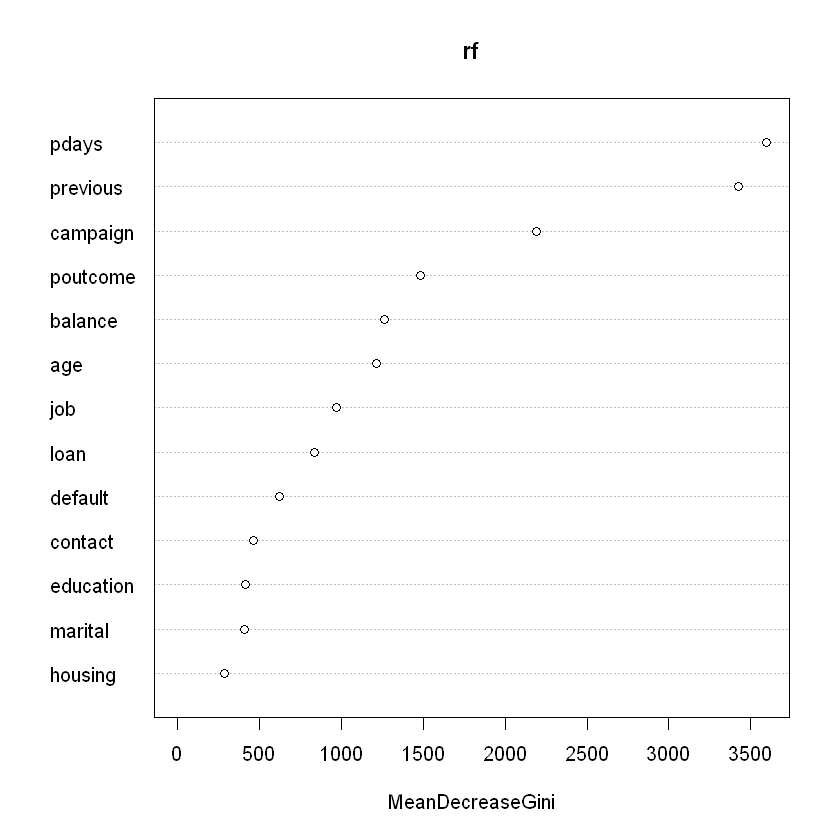

In [130]:
varImpPlot(rf)

In [132]:
lm(y~., data = train)

Warning message in model.response(mf, "numeric"):
"using type = "numeric" with a factor response will be ignored"Warning message in Ops.factor(y, z$residuals):
"'-' not meaningful for factors"


Call:
lm(formula = y ~ ., data = train)

Coefficients:
       (Intercept)                 age      jobblue-collar     jobentrepreneur  
         1.631e+00          -9.134e-04          -9.726e-02          -7.748e-02  
      jobhousemaid       jobmanagement          jobretired    jobself-employed  
        -1.256e-01          -5.066e-02           2.569e-02          -1.995e-02  
       jobservices          jobstudent       jobtechnician       jobunemployed  
        -6.109e-02           1.232e-02          -1.019e-01           1.149e-02  
        jobunknown      maritalmarried       maritalsingle  educationsecondary  
        -2.583e-02          -1.530e-01          -7.209e-02          -1.301e-02  
 educationtertiary    educationunknown          defaultyes             balance  
         6.376e-02           8.045e-02           3.235e-01           1.747e-06  
        housingyes             loanyes    contacttelephone      contactunknown  
        -7.559e-02           2.341e-01           1.62

# Limitations of our Analysis

# Conclusion

Lorem ipsum dolor sit amet, est nibh atqui commune cu, simul tritani propriae ex mel. Tamquam alienum reprehendunt an sed. Vix deleniti perfecto ne, mei prodesset reprimique eu, ius ei commodo molestiae. Ne phaedrum accusata disputationi sea, id qui malorum efficiantur. Quo ad possim oblique graecis, his ex iriure eligendi corrumpit.

His diam forensibus contentiones et, vix sumo expetenda et. Ut magna dicant consectetuer vel, dicta platonem temporibus eos id. Choro civibus insolens et vis, qui eu legendos patrioque, latine eloquentiam liberavisse eam at. Quod meis ullum et mel. Facilisi instructior eam ad.

Accusamus consequat eam cu, pri id docendi ancillae perfecto. No pro quando disputationi. Sea et eros putent utamur, an iriure prompta comprehensam nec. At qui latine nominati complectitur, cu vim iudico graeco accusam.

Usu ex vidit voluptatum. Sed aliquip quaeque mentitum et. Populo quaeque assueverit per no, pro erroribus conceptam reformidans id. Et meis homero per. Vide quaestio in vel, vix amet sumo dolorem ex, eam te sonet inermis.

Mei an vulputate reformidans, an doctus corpora sed. Iriure omittantur vis ut, dicit errem veritus ne eam. Et nec justo scaevola necessitatibus, mazim persecuti ex mel, ut iriure debitis sea. In his quis detracto consulatu. Appareat consectetuer sea ad, ea est dolor albucius. Duo sonet accusamus appellantur no, quo an purto erat placerat, eu congue labitur corrumpit est.